In [ ]:
import zipfile
import pandas as pd
import os

# Path to the ZIP file and the extraction directory
zip_path = "Data.zip"
extract_dir = "extracted_csvs"
required_files = ['Data/cleaned_balance_data.csv', 'Data/cleaned_subregion_data.csv']

# Step 1: Extract the required CSV files from the 'Data/' folder in the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:

    for file_name in zip_ref.namelist():
        if any(req_file in file_name for req_file in required_files):
            zip_ref.extract(file_name, extract_dir)

# Step 2: Load the extracted CSVs into DataFrames
balance_file = os.path.join(extract_dir, 'Data/cleaned_balance_data.csv')
subregion_file = os.path.join(extract_dir, 'Data/cleaned_subregion_data.csv')

# Ensure the files exist before reading
if os.path.exists(balance_file) and os.path.exists(subregion_file):
    balance_df = pd.read_csv(balance_file)
    subregion_df = pd.read_csv(subregion_file)
    # Step 3: Filter out necessary columns from each DataFrame
    balance_df_filtered = balance_df[['city', 'demand', 'utc_time']].rename(columns={'utc_time': 'time'})
    subregion_df_filtered = subregion_df[['city', 'demand', 'utc_time']].rename(columns={'utc_time': 'time'})

    combined_df = pd.concat([balance_df_filtered, subregion_df_filtered], ignore_index=True)


In [ ]:
# Strip whitespace and convert to lowercase for consistent matching
combined_df['city'] = combined_df['city'].str.strip().str.lower()

In [ ]:
import zipfile
import pandas as pd

zip_path = "Data.zip"
json_dfs = []
selected_columns = ['time','pressure', 'temperature', 'humidity','windSpeed','precipProbability','precipIntensity']

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file_name in zip_ref.namelist():
        if file_name.endswith('.json'):
            with zip_ref.open(file_name) as f:
                df = pd.read_json(f)
                df = df[[col for col in selected_columns if col in df.columns]].copy()
                df['city'] = file_name.split("/")[-1].replace(".json", "")
                json_dfs.append(df)

combined_json_df = pd.concat(json_dfs, ignore_index=True)
combined_json_df['time'] = pd.to_datetime(combined_json_df['time'], unit='s')
combined_json_df['city'].value_counts()
combined_json_df.head()

,time,pressure,temperature,humidity,windSpeed,precipProbability,precipIntensity,city
0,2018-07-02 05:00:00,1011.9,89.56,0.45,10.84,0.0,0.0,dallas
1,2018-07-02 06:00:00,1012.7,88.35,0.52,9.94,0.0,0.0,dallas
2,2018-07-02 07:00:00,1012.8,87.05,0.56,8.92,0.0,0.0,dallas
3,2018-07-02 08:00:00,1012.7,86.04,0.58,8.47,0.0,0.0,dallas
4,2018-07-02 09:00:00,1012.9,84.80,0.63,5.61,0.0,0.0,dallas


In [ ]:
# Convert 'time' columns to datetime format
combined_df['time'] = pd.to_datetime(combined_df['time'])
combined_json_df['city'] = combined_json_df['city'].str.strip().str.lower()
combined_json_df['time'] = pd.to_datetime(combined_json_df['time'])

In [ ]:
# Align timezones if necessary
combined_df['time'] = combined_df['time'].dt.tz_localize(None)
combined_json_df['time'] = combined_json_df['time'].dt.tz_localize(None)
merged_df = pd.merge(combined_json_df, combined_df[['city', 'time', 'demand']], on=['city', 'time'], how='left')

In [ ]:
# Sort the dataset by year in the 'time' column
merged_df = merged_df.sort_values(by='time')
merged_df.to_csv('merged_data.csv', index=False)
# Check the result


In [ ]:
merged_df['demand'] = merged_df['demand'].fillna(merged_df['demand'].mean())

In [ ]:
merged_df.head()

,time,pressure,temperature,humidity,windSpeed,precipProbability,precipIntensity,city,demand
116018,2018-07-01 07:00:00,1015.9,61.71,0.80,3.53,0.0,0.0,san_diego,6644.228866
132592,2018-07-01 07:00:00,1012.8,67.78,0.60,6.36,0.0,0.0,san_jose,6644.228866
82870,2018-07-01 07:00:00,1008.9,86.82,0.16,4.30,0.0,0.0,phoenix,6644.228866
33148,2018-07-01 07:00:00,1014.5,65.45,0.79,4.23,0.0,0.0,la,6644.228866
149166,2018-07-01 07:00:00,1022.1,59.32,0.86,4.81,0.0,0.0,seattle,6644.228866


In [ ]:
# Forward fill time-series data (suitable for demand and weather)
merged_df = merged_df.sort_values(by=['city', 'time'])
merged_df[['temperature', 'humidity', 'windSpeed', 'pressure', 'precipProbability', 'precipIntensity', 'demand']] = (
    merged_df[['temperature', 'humidity', 'windSpeed', 'pressure', 'precipProbability', 'precipIntensity', 'demand']]
    .fillna(method='ffill')
)

# Optionally, backfill to catch beginning nulls
merged_df.fillna(method='bfill', inplace=True)

# If any nulls still exist, drop them (last resort)
merged_df.dropna(inplace=True)


/tmp/ipykernel_33415/908283540.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')
/tmp/ipykernel_33415/908283540.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='bfill', inplace=True)


In [ ]:
# Extract time-based features
merged_df['hour'] = merged_df['time'].dt.hour
merged_df['day_of_week'] = merged_df['time'].dt.dayofweek
merged_df['month'] = merged_df['time'].dt.month
merged_df['season'] = merged_df['month'] % 12 // 3 + 1  # 1: Winter, 2: Spring, etc.


In [ ]:
from sklearn.preprocessing import StandardScaler

# Select numerical features to scale
numeric_cols = ['temperature', 'humidity', 'windSpeed', 'pressure',
                'precipProbability', 'precipIntensity', 'demand', 'hour', 'day_of_week', 'month']

scaler = StandardScaler()
merged_df_scaled = merged_df.copy()

# Apply scaling
merged_df_scaled[numeric_cols] = scaler.fit_transform(merged_df[numeric_cols])


In [ ]:
from scipy.stats import zscore

# Use z-score on selected features
z_scores = merged_df_scaled[['demand', 'temperature', 'humidity']].apply(zscore)

# Flag rows with any feature having z-score > 3 or < -3 as anomaly
anomaly_mask = (z_scores.abs() > 3).any(axis=1)
anomalies_zscore = merged_df_scaled[anomaly_mask]

print(f"Z-Score Anomalies Detected: {len(anomalies_zscore)}")


Z-Score Anomalies Detected: 2857


In [ ]:
from sklearn.ensemble import IsolationForest

# Features to use
features = ['temperature', 'humidity', 'windSpeed', 'pressure',
            'precipProbability', 'precipIntensity', 'demand', 'hour', 'day_of_week', 'month']

iso_forest = IsolationForest(contamination=0.01, random_state=42)
merged_df_scaled['anomaly'] = iso_forest.fit_predict(merged_df_scaled[features])

# -1 = anomaly, 1 = normal
anomalies_iso = merged_df_scaled[merged_df_scaled['anomaly'] == -1]

print(f"Isolation Forest Anomalies Detected: {len(anomalies_iso)}")


Isolation Forest Anomalies Detected: 1658


In [ ]:
merged_df_cleaned = merged_df_scaled[merged_df_scaled['anomaly'] == 1]


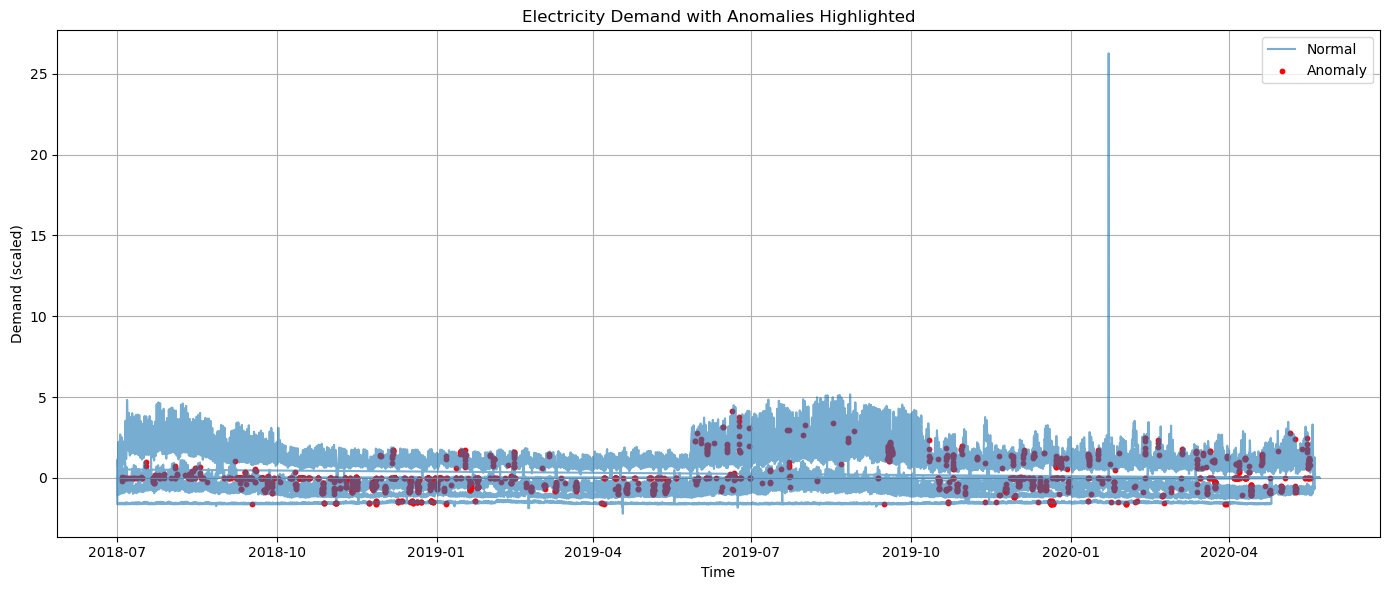

In [ ]:
import matplotlib.pyplot as plt

# Separate normal and anomalous points
normal = merged_df_scaled[merged_df_scaled['anomaly'] == 1]
anomaly = merged_df_scaled[merged_df_scaled['anomaly'] == -1]

plt.figure(figsize=(14, 6))
plt.plot(normal['time'], normal['demand'], label='Normal', alpha=0.6)
plt.scatter(anomaly['time'], anomaly['demand'], color='red', label='Anomaly', s=10)
plt.xlabel('Time')
plt.ylabel('Demand (scaled)')
plt.title('Electricity Demand with Anomalies Highlighted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.decomposition import PCA

# Drop non-numeric columns and anomaly flag
clustering_features = merged_df_scaled.drop(columns=['city', 'time', 'anomaly'])

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(clustering_features)

# Add PCA results back
merged_df_scaled['pca1'] = pca_result[:, 0]
merged_df_scaled['pca2'] = pca_result[:, 1]


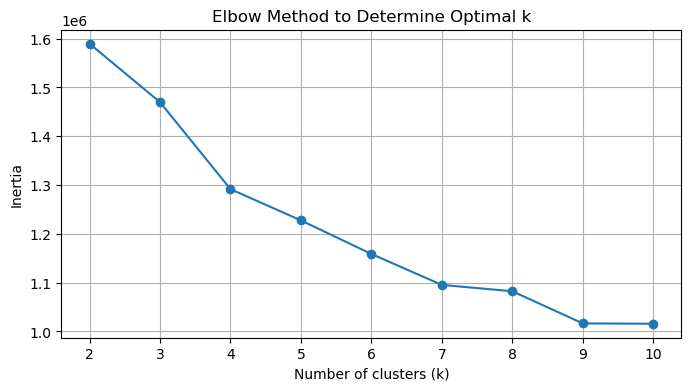

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


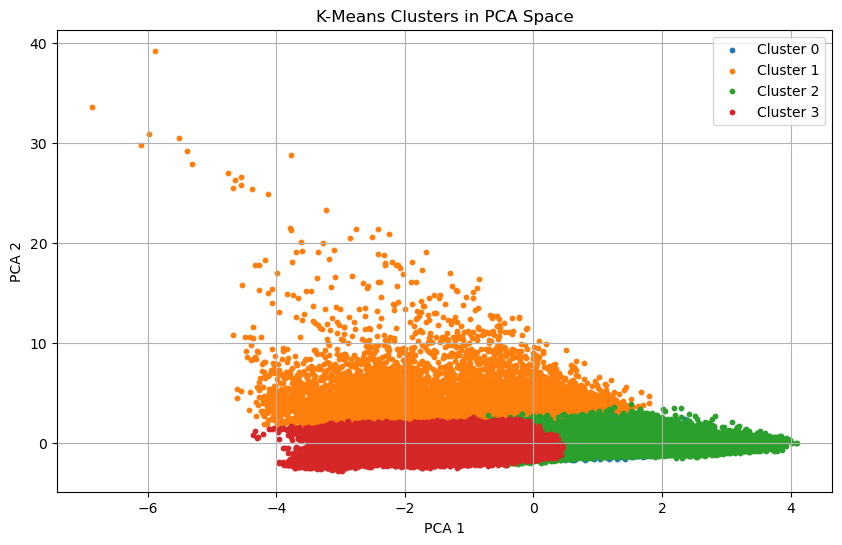

In [ ]:
# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
merged_df_scaled['cluster'] = kmeans.fit_predict(clustering_features)

# Plot clusters in PCA space
plt.figure(figsize=(10, 6))
for c in range(4):
    subset = merged_df_scaled[merged_df_scaled['cluster'] == c]
    plt.scatter(subset['pca1'], subset['pca2'], label=f'Cluster {c}', s=10)

plt.title('K-Means Clusters in PCA Space')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

score = silhouette_score(clustering_features, merged_df_scaled['cluster'])
print(f"Silhouette Score: {score:.3f}")


Silhouette Score: 0.146


In [ ]:
merged_df_scaled.groupby('cluster')[['temperature', 'demand', 'humidity']].mean()


,temperature,demand,humidity
cluster,,,
0,0.066085,-0.148349,0.379627
1,-0.471236,-0.244115,1.095059
2,1.147191,0.491639,-0.892366
3,-0.657539,-0.148711,0.110158


In [ ]:
df_model = merged_df_scaled.copy()

# Sort by city and time
df_model = df_model.sort_values(['city', 'time'])

# Add lag features (e.g., demand from same hour previous day)
df_model['demand_lag_24h'] = df_model.groupby('city')['demand'].shift(24)

# Drop rows with NaN (from shifting)
df_model = df_model.dropna()


In [ ]:
# Make sure time column is in datetime format
df_model['time'] = pd.to_datetime(df_model['time'])

# Extract time-based features
df_model['hour'] = df_model['time'].dt.hour
df_model['dayofweek'] = df_model['time'].dt.dayofweek
df_model['month'] = df_model['time'].dt.month

# Optional: Add season (0=Winter, 1=Spring, 2=Summer, 3=Fall)
def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Fall

df_model['season'] = df_model['month'].apply(get_season)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Time-based split (e.g., last 7 days as test)
cutoff_time = df_model['time'].max() - pd.Timedelta(days=7)
train_df = df_model[df_model['time'] < cutoff_time]
test_df = df_model[df_model['time'] >= cutoff_time]

X_cols = ['temperature', 'humidity', 'pressure', 'windSpeed', 'precipProbability', 'hour', 'dayofweek', 'month', 'season', 'demand_lag_24h']
y_col = 'demand'

X_train = train_df[X_cols]
y_train = train_df[y_col]
X_test = test_df[X_cols]
y_test = test_df[y_col]


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

mae = mean_absolute_error(y_test, lr_preds)
rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
mape = np.mean(np.abs((y_test - lr_preds) / y_test)) * 100

print(f"Linear Regression → MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")


Linear Regression → MAE: 0.17, RMSE: 0.44, MAPE: 43143414271938584.00%


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print(f"Random Forest → MAE: {mean_absolute_error(y_test, rf_preds):.2f}, RMSE: {np.sqrt(mean_squared_error(y_test, rf_preds)):.2f}")


Random Forest → MAE: 0.14, RMSE: 0.45


In [ ]:
naive_preds = test_df['demand_lag_24h']  # just use previous day’s same hour
print(f"Naive Forecast → MAE: {mean_absolute_error(y_test, naive_preds):.2f}")


Naive Forecast → MAE: 0.16


In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

print(f"XGBoost → MAE: {mean_absolute_error(y_test, xgb_preds):.2f}, RMSE: {np.sqrt(mean_squared_error(y_test, xgb_preds)):.2f}")


XGBoost → MAE: 0.14, RMSE: 0.44


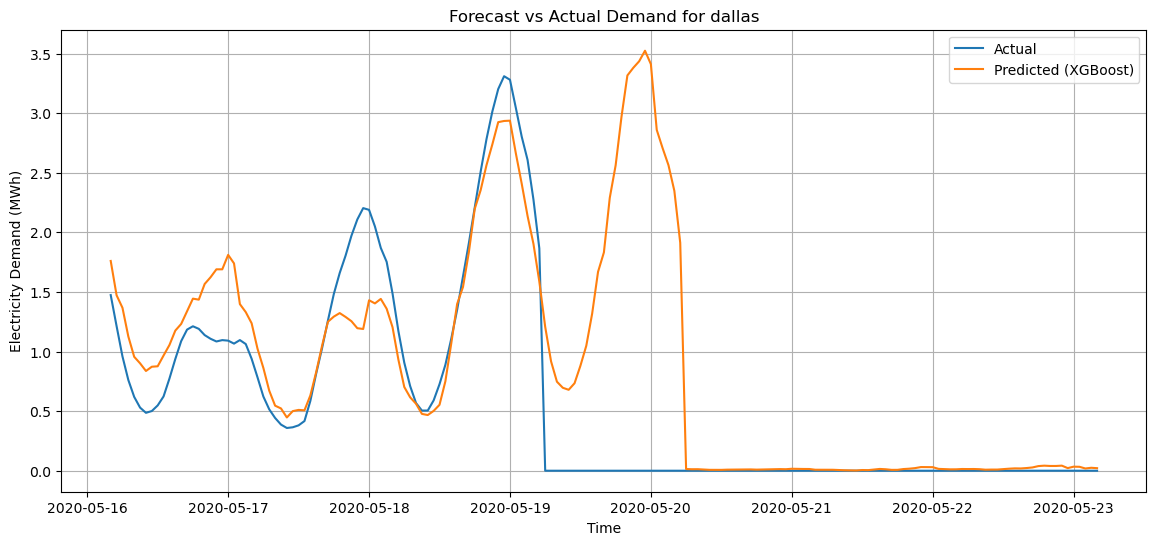

In [ ]:
import matplotlib.pyplot as plt

test_df_plot = test_df.copy()
test_df_plot['predicted_demand'] = xgb_preds
sample_city = test_df_plot['city'].unique()[0]

sample_data = test_df_plot[test_df_plot['city'] == sample_city]

plt.figure(figsize=(14, 6))
plt.plot(sample_data['time'], sample_data['demand'], label='Actual')
plt.plot(sample_data['time'], sample_data['predicted_demand'], label='Predicted (XGBoost)')
plt.title(f"Forecast vs Actual Demand for {sample_city}")
plt.xlabel('Time')
plt.ylabel('Electricity Demand (MWh)')
plt.legend()
plt.grid(True)
plt.show()
